This notebook provides the code used for image analysis in Dorison et al. (2022), published in JASN. It was written in python with some analysis done using Fiji/ImageJ. 

It is highly recommended that you view this notebook in [Colab](https://). The imaging dataset is available at https://doi.org/10.25374/MCRI.21067654


# Setup

### Environment

Setup a new conda environment using the following code block in the Anaconda/Miniconda Powershell prompt.

```
conda create -y -n nphs2-env -c conda-forge python=3.9
conda activate nphs2-env
conda install seaborn matplotlib h5py
pip install jupyter_http_over_ws statannotations
jupyter serverextension enable --py jupyter_http_over_ws
python -m pip install "napari[all]"

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8000 --Noteb
ookApp.port
```
After activating your environment, make sure to connect to a local runtime when running this notebook (using dropdown arrow next to "Connect").

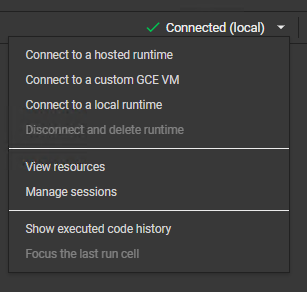

## Input directory structure

Download the 3 zip files available at [Figshare](https://doi.org/10.25374/MCRI.21067654). Unzip them into the same folder (`INPUT/ROOT/PATH`).

The file structure should be as shown below.

* `dataset` contains the original imaris (`.ims`), arranged into subfolders by subcellar marker and then subfolder with the channel names of the images in order.

* `edited_ROIs` folder contains binary TIF images of the selected ROI for the corresponding ims image with the same filename.

* `imageJ_rollingball` folder contains a subfolder all_tifs_rb50 that contains TIF files of each channel of the raw images processed with ImageJ's implementation of rolling ball background subtraction with radius of 50.  

```
INPUT/ROOT/PATH
└───dataset
    └───EEA1
        └───DAPI_NPHS1_NPHS2_EEA1
            |--ADIF96_EEA1_AD2156_808.5_100x_2022-01-19_11.51.44_Aude Dorison.ims
            |--ADIF96_EEA1_AD2156_808.5_100x_2022-01-19_11.50.45_Aude Dorison.ims
            |--...
            |--2020-12-21_13.12.07_ADIF51_EEA1_G92C_Aude Dorison.ims
    └───GM130
        └───DAPI_NPHS1_NPHS2_GM130
            |--2020-11-09_11.08.44_ADIF40_GM130_808.3_Aude Dorison.ims
            |--...
    └───KDEL
        └───DAPI_KDEL_NPHS2_NPHS1
            |--ADIF82_KDEL_808.3_CTL_2021-08-19_10.43.59_Aude Dorison.ims
            |--...
        └───KDEL_DAPI_NPHS2_NPHS1
            |--ADIF68_KDEL_Proband_100x_2021-06-17_11.52.00_Aude Dorison.ims
            |--...
    └───Rab7
        └───DAPI_Rab7_NPHS2_NPHS1
            |--ADIF83_Rab7_808.3_CTL_2021-08-20_10.57.25_Aude Dorison.ims
            |--...
        └───Rab7_DAPI_NPHS2_NPHS1
            |--ADIF69_Rab7_Proband_100x_2021-06-17_13.07.41_Aude Dorison.ims
            |--...
    └───SYNPO
        └───DAPI_LAMA5_NPHS2_SYNPO
            |--ADIF79_SYNPO_LAMA5_808.3_CTL_2021-08-17_16.21.19_Aude Dorison.ims
            |--...
└───edited_ROIs
    |--....tif
└───imagej_rollingball
    └───all_tifs_rb50 
        |--....tif

```



### Output directory structure

After running the cells, the analysis will be saved using this directory structure. Note that only EEA1 is shown here as an example, but this structure will be repeated for each subcellular marker.

`read files.csv` list of all images that were successfully read in initially

`{CHANNEL1}_{CHANNEL-2_LIST}_{DATE}_{TIME}.csv` CSV file with the metrics that were measured for particular combinations of channels.

`graphs` high resolution PNG images of all graphs

```
INPUT/ROOT/PATH
└───dataset analysis
    └───EEA1
        └───images 
            └───*folder for each mutant line*
                |-- *image layer in napari.tif*
            |-- read_files.csv
            |-- {CHANNEL1}_{CHANNEL-2_LIST}_{DATE}_{TIME}.csv
└───graphs
    |-- {CHANNEL1} {CHANNEL2} {PATIENT or MUTANT} {METRIC}.png
```

## How to use the notebook
Now that you have setup the environment and downloaded the files, run the analysis (from "`Loading images`" to "`Measure key metrics`") with each subcellular marker (which is specificied in `Setup single subcellular marker analysis` in `Loading images` section). This will generate a file called `dataset analysis` that stores the results and processed files. 

Once the results for all subcellular markers have been generated, run `Graphs` to generate graphs.

# Loading images

In [ ]:
import napari
from skimage import measure, filters, restoration, morphology
from skimage.morphology import disk
import re
import glob
import numpy as np
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
import os
from datetime import datetime
from PIL import Image
import h5py
import tifffile
from copy import deepcopy

#@markdown ###Setup single subcellular marker analysis


#@markdown Specific subceullar marker to analyse
#subcellular markers = [x[0] for x in os.walk(INPUT_ROOT_PATH)][1:] # subdir list
subcellular_marker = "EEA1" #@param ["EEA1", "GM130", "KDEL", "Rab7", "SYNPO", "LAMP1"]

#@markdown Folder to store results. 
INPUT_ROOT_PATH = "\\\\data.mcri.edu.au\\kidn1\\Group-Little_MCRI\\People\\Thanushi\\aude" #@param {type:"string"}

filetype = "ims"
exclude_fps_with = ["20x", "x20", "x40"]

# condition groups in correct order for graphmaking and reading in
groups = [["_CTL_", "808.3", "808.5"], "G92C", "P118L",
          ["R138Q", "R-138Q"], "R168H", "R291W", ["Unaffected", "un_"], ["Proband", "pro_"]]
CONTROL_CONDITIONS = {"808.3", "808.5",'_CTL_', "un_", 'Unaffected'}
mutant_lines = ["808.3", "808.5", "_CTL_", "G92C", "P118L", "R138Q", "R168H", "R291W"]
patient_lines = ["Unaffected", "un_", "Proband", "pro_"]

channel1 = subcellular_marker
if channel1=="SYNPO":
  channel2_list=["NPHS2"]
else:
  channel2_list = ["NPHS2", "NPHS1"]

# colours and meaning reference
channel_meaning_dict = {
"KDEL": "ER",
"KDEL patient": "ER",
"GM130": "Golgi",
"GM130 patient": "Golgi",
"GM130-compound-24wp": "Golgi",
"GM130-compound-384wp": "Golgi",
"SYNPO": "membrane",
"NPHS1": "nephrin",
"NPHS2": "podocin",
"DAPI": "nucleus",
"LAMA5": "ECM",
"Rab7": "late endosome",
"Rab7 patient": "late endosome",
"EEA1": "early endosome",
"EEA1 patient": "early endosome",
"LAMP1": "lysosome",
"LAMP1 patient": "lysosome"
}

channel_colours_dict = {
"KDEL": "green",
"KDEL patient": "green",
"GM130": "green",
"GM130 patient": "green",
"GM130-compound-24wp": "green",
"GM130-compound-384wp": "green",
"SYNPO": "green",
"NPHS1": "gray",
"NPHS2": "red",
"DAPI": "blue",
"LAMA5": "gray",
"Rab7": "green",
"Rab7 patient": "green",
"EEA1": "green",
"LAMP1": "green",
"LAMP1 patient": "green"
}


In [ ]:
#@markdown ###Load images in napari

### FUNCTIONS
channels_func = lambda image_fp: os.path.basename(os.path.dirname(image_fp)).split("_")
image_id = lambda fp: os.path.basename(fp)[:-4]

def setup_folders(INPUT_ROOT_PATH, subcellular_marker, channel1):
    # ROOT_PATHS
    INPUT_ROOT_PATH_C1 = os.path.join(INPUT_ROOT_PATH, "dataset", channel1)
    output_path_c1 = os.path.join(INPUT_ROOT_PATH, "dataset analysis", channel1)
    if not os.path.exists(INPUT_ROOT_PATH_C1):
        raise Warning(f"{channel1} data not found in specified input filepath {INPUT_ROOT_PATH_C1}.")
    ROOT_PATHS = [x[0] for x in os.walk(INPUT_ROOT_PATH_C1)][1:] # subdir list

    # setup image output folder
    if subcellular_marker != channel1:
        output_path_c1 = os.path.join(output_path_c1, subcellular_marker)
    if not os.path.exists(output_path_c1):
        os.makedirs(output_path_c1)
    image_output_folder = os.path.join(output_path_c1, "images")
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    return ROOT_PATHS, output_path_c1, image_output_folder

def setup_folders_imageJrollingballtifs(INPUT_ROOT_PATH):
    # setup for imageJ rolling ball tiffs
    base_folder = os.path.join(INPUT_ROOT_PATH, 'imagej_rollingball')
    all_tifs = os.path.join(base_folder, "all_tifs")
    all_tifs_rb50 = all_tifs+"_rb50"
    for fp in [all_tifs, all_tifs_rb50]:
        if not os.path.exists(fp):
            print("WARNING: you have not got subtract background tifs from",
                  "imageJ, please run section save images as tif for rolling ball in imageJ")
            os.makedirs(fp)
    return all_tifs, all_tifs_rb50



def get_fps_grouped(root_paths, filetype, groups=None, exclude_in_name=[]):
    files = get_fps_with_ext(root_paths, filetype)
    files_dict = divide_fps_into_groups(files, groups, 
                                        exclude_in_name)
    return files_dict

def get_fps_with_ext(root_paths, filetype):
    paths = []
    for rp in root_paths:
        paths+=glob.glob(os.path.join(rp, f"*{filetype}"))
    return sorted(paths)

# split files into different viewers by substring in filename
def divide_fps_into_groups(files, groups=None, exclude_in_name=[]):
    #files = sorted(glob.glob(os.path.join(ROOT_PATH, f"*{filetype}")))
    files_dict = {}
    if groups is not None:
        for group in groups:

            # pools several labels together, as specified by groups list of lists
            if isinstance(group, list):
                g_label = group[0] # first label in list is used to label rest
                files_dict[g_label] = [f for f in files if any(g.lower() in os.path.split(f)[-1].lower() for g in group)]
            elif isinstance(group, str):
                g_label = group
                files_dict[g_label] = [f for f in files if g_label.lower() in os.path.split(f)[-1].lower()]
            else:
                raise ValueError(f"{group} in groups should be a string or list of strings")
            

            # remove filepaths whose name contains any of the terms in exclude_in_name list
            if exclude_in_name: 
                files_dict[g_label] = [f for f in files_dict[g_label] if 
                                 not any(exclude in os.path.split(f)[-1].lower() for exclude in exclude_in_name)]
    else:
        files_dict["all"] = files
    return files_dict



def dict_dask_viewer(files_dict, channels, channel_colours_dict, 
                     subcellular_marker, resolutionLevel=0,
            select_images_same_dimensions_as_image_num=0, verbose=False):
    viewers_dict = {}
    all_dask_dict = {}
    read_files_dict = {}
    for k in files_dict.keys():
        if len(files_dict[k])==0: continue # skips conditions with no images
        all_dask_dict[k], viewers_dict[k], read_files_dict[k], channels_new = dask_viewer(
            files_dict[k], channels, channel_colours_dict, 
            viewer_name=f"{subcellular_marker} {k}", resolutionLevel=resolutionLevel,
            select_images_same_dimensions_as_image_num=select_images_same_dimensions_as_image_num,
            verbose=False
            )
    return all_dask_dict, viewers_dict, read_files_dict, channels_new

def dask_viewer(files, channels_func, channel_colours_dict, viewer_name = None, 
                resolutionLevel=0, 
                select_images_same_dimensions_as_image_num=None,
                verbose=False):

    all_dask, fps, channel_names = get_daskarray_from_ims_fps(
        files, resolutionLevel=resolutionLevel, channels_func=channels_func, 
        select_images_same_dimensions_as_image_num=select_images_same_dimensions_as_image_num,
        verbose=verbose)

    # load multichannel image in (note assumes channel is on axis 1)
    viewer = napari.view_image(all_dask, channel_axis=1, title=viewer_name, name=channel_names)

    # customise layers
    for c in channel_names:
        viewer.layers[c].colormap = channel_colours_dict[c]

    return all_dask, viewer, fps, channel_names

def get_daskarray_from_ims_fps(fps, resolutionLevel, channels_func, 
                               select_images_same_dimensions_as_image_num=None,
                               verbose=False):

    first_channels = channels_func(fps[0])
    if verbose: print("first_channels", first_channels)

    # channels might be input as list or dictionary where key is parent filepath and value is list
    images_data = []
    for fp in fps:
        channels_order = channels_func(fp)
        channels_i = [channels_order.index(ch) for ch in first_channels]
        if verbose and (channels_order != first_channels):
            print("changed axes order", channels_order, channels_i, os.path.split(fp)[1])
        images_data.append(get_daskarray_from_ims(fp, resolutionLevel, channels_i))

    read_fps = fps

    if select_images_same_dimensions_as_image_num !=None:
        reference_shape = images_data[select_images_same_dimensions_as_image_num].shape
        #images_data = [im for im in images_data if im.shape==reference_shape]
        images_data_same_shape = []
        for i in range(len(images_data)):
            im = images_data[i]
            if im.shape==reference_shape:
                images_data_same_shape.append(im)
            else:
                print(f"WARNING: excluded {fps[i]} as has image size {im.shape} instead of {reference_shape}")
                read_fps[i] = ""
        images_data = images_data_same_shape

    return da.stack(images_data), [fp for fp in read_fps if fp], first_channels

# function that reads in ims filepath and returns dask array
def get_daskarray_from_ims(fp, resolutionLevel, channels_i):
    #print("  reading:", fp)
    hf = h5py.File(fp, 'r')
    dataset = hf.get("DataSet").get(f"ResolutionLevel {resolutionLevel}").get("TimePoint 0")
    #hf.visit(print) #prints out all nodes in hdf5

    # extract the Data, you also have Histogram btw
    img_ch_list = []
    for ch in channels_i:
        new_ch = dataset.get(f"Channel {ch}").get('Data')
        n_z, n_y, n_x = new_ch.shape
        #print(new_ch.shape)
        new_ch = da.from_array(new_ch, chunks=(n_z, n_y, n_x))
        
        img_ch_list.append(new_ch)
            
    img = da.stack(img_ch_list)
    #print("     size of arr:", img.shape)
    return img#.astype(np.uint8)


### SCRIPT

# setup folders
ROOT_PATHS, OUTPUT_ROOT_PATH, image_output_folder = setup_folders(
    INPUT_ROOT_PATH, subcellular_marker, channel1)
all_tifs, all_tifs_rb50 = setup_folders_imageJrollingballtifs(INPUT_ROOT_PATH)

# get files
files_dict = get_fps_grouped(
    ROOT_PATHS, filetype, groups=groups, exclude_in_name=exclude_fps_with)

# read files into viewer, skips those that don't match dimension of 1st image
print("IMAGES THAT WERE EXCLUDED BECAUSE THEY WERE OF DIFFERING DIMENSIONS (if no image names follow, all is well)")
all_dask_dict, viewers_dict, read_files_dict, channels = dict_dask_viewer(
    files_dict, channels_func, channel_colours_dict, subcellular_marker,
    resolutionLevel=0, select_images_same_dimensions_as_image_num=0)

# record files that were read for each condition
csv_file = os.path.join(OUTPUT_ROOT_PATH, "read_files.csv")
rows = []
for k in read_files_dict.keys():
    for i in range(len(read_files_dict[k])):
        row = {}
        row["condition"] = k
        row["viewer_axis_i"] = i
        row["image_id"] = image_id(read_files_dict[k][i])
        row["fp"] = read_files_dict[k][i]
        rows.append(row)

df = pd.DataFrame(rows)
df.to_csv(csv_file, index=False)
print(f"files read in were logged to:\n{csv_file}")


IMAGES THAT WERE EXCLUDED BECAUSE THEY WERE OF DIFFERING DIMENSIONS (if no image names follow, all is well)
files read in were logged to:
\\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\EEA1\read_files.csv


# Processing

## Record of preliminary processing
These cells document the process used to create the data in  `imageJ_rollingball` and `edited_ROI` folders that can be downloaded directly from <a href="https://doi.org/10.25374/MCRI.21067654">Figshare</a></b>. Skip these cells if you have downloaded those folders.

In [ ]:
#@markdown ###Save channels as tifs to run rolling ball in Fiji/ImageJ
#@markdown 
#@markdown ImageJ rollingball was used to subtract the backround, with a radius of 50. 
#@markdown 
#@markdown After running this cell, open `Fiji > Process > Batch > Macro` and use the following code.
#@markdown
#@markdown Input folder: `INPUT_ROOT_PATH\imagej_rollingball\all_tifs`
#@markdown 
#@markdown Output folder: `INPUT_ROOT_PATH\imagej_rollingball\all_tifs_rb50`
#@markdown
#@markdown Output format: `TIFF`
#@markdown ```
#@markdown run("Subtract Background...", "rolling=50 stack");
#@markdown close();
#@markdown ```

#@markdown Then continue running cells below

# save all images as tifs - run rolling ball in imagej then put back in
for condition in read_files_dict:
    for i in range(len(read_files_dict[condition])):
        img = all_dask_dict[condition][i].compute()
        for channel in channels:
            im_ch = img[channels.index(channel),0,:,:]
            path = os.path.join(all_tifs, f"{os.path.split(read_files_dict[condition][i])[1][:-4]}_{channel}.tiff")
            if "R-138Q" in path:
                print(i, path)
                image = Image.fromarray(im_ch)
                image.save(path)
                #plt.imsave(path, im_ch, cmap='gray')


In [ ]:
#@markdown ###Generate preliminary ROIs that were then edited by hand
#@markdown The edited ROIs can be downloaded separately and put into the folder structure given above

# reads in roi if saved, otherwise makes the roi and displays on viewer for editing 
from tifffile import imread
for condition in all_dask_dict.keys():
    viewer = viewers_dict[condition]

    roi_fp = os.path.join(image_output_folder, condition, "roi.tif")
    if os.path.exists(roi_fp):
        
        #viewer.open(roi_fp, blending="additive", opacity=0.4)
        im = imread(roi_fp)
        roi = np.array(im)
        print(condition, "using saved ROI", im.shape)
        

    else: 
        roi = np.zeros(viewers_dict[condition].layers[0].data.shape)
        for i in range(len(read_files_dict[condition])):
            img = all_dask_dict[condition][i].compute()
            one_channel = img[0,0,:,:]
            if "NPHS1" in channels:
                roi[i,:,:,:] = morphology.remove_small_holes(gaussian_otsu(img[channels.index("NPHS1"),0,:,:], sigma=70), area_threshold=np.product(one_channel.shape)//20)##############
            elif "SYNPO" in channels:
                roi[i,:,:,:] = morphology.remove_small_holes(gaussian_otsu(img[channels.index("SYNPO"),0,:,:], sigma=70), area_threshold=np.product(one_channel.shape)//20)##############
                roi[i,:,:,:] = np.logical_or(roi[i,:,:,:], morphology.remove_small_holes(gaussian_otsu(img[channels.index("NPHS2"),0,:,:], sigma=70), area_threshold=np.product(one_channel.shape)//20))
    viewer.add_image(roi, opacity=0.4, name=f"roi", colormap="gray", visible=True, blending="additive")

_CTL_ using saved ROI (14, 1, 2048, 2048)
G92C using saved ROI (11, 1, 2048, 2048)
P118L using saved ROI (10, 1, 2048, 2048)
R138Q using saved ROI (11, 1, 2048, 2048)
R168H using saved ROI (10, 1, 2048, 2048)
R291W using saved ROI (10, 1, 2048, 2048)
Unaffected using saved ROI (10, 1, 2048, 2048)
Proband using saved ROI (10, 1, 2048, 2048)


## Process channels

In [ ]:
#@markdown ###Generate and save processed channels (run ONCE for each subcellular marker)
#@markdown  If you downloaded all folders from <a href="">Figshare</a></b> and arranged them as specificed in the `Input directory structure` section of this notebook, run this block once for each subcellular marker (set in `Loading images` section of notebook) 
#@markdown to generate the processed channels and automatically save them to your computer. Once this block has executed, you will see the channels loaded onto napari and you can skip the `Load saved processing` block below.

# CONVENIENCE THRESHOLDING
def gaussian_otsu(img, sigma, fp_npysave=None):
    image_filtered = filters.gaussian(img, sigma=sigma)
    image_otsu = otsu(image_filtered).astype(int)
    if fp_npysave is not None: np.save(fp_npysave, image_otsu)
    return image_otsu

def local_thresholding_perimage(image, selem=None):##############################!!!!!!!!!!!!!!!!!!!!!!
    median_filtered = filters.median(image, selem=selem)
    minus_background = np.subtract(image, median_filtered)
    minus_background = np.where(minus_background<0, 0, minus_background)######
    local_thresholded = otsu(minus_background)

    return local_thresholded

def local_thresholding_allimages(image, selem=None):##############################!!!!!!!!!!!!!!!!!!!!!!
    median_filtered = np.zeros(image.shape)
    for s in range(image.shape[0]):
        median_filtered[s,:,:,:] = filters.median(image[s,:,:,:], selem=selem)
    
    minus_background = np.subtract(image, median_filtered)
    local_thresholded = otsu(minus_background)

    return local_thresholded

def otsu(image):
    thresh = filters.threshold_otsu(image)
    mask = image > thresh
    print(f"otsu thresh is: {thresh}")
    return mask

def triangle(image):
    thresh = filters.threshold_triangle(image)
    mask = image > thresh
    print(f"triangle thresh is: {thresh}")
    return mask

def local_thresholding(image):##############################!!!!!!!!!!!!!!!!!!!!!!
    median_filtered = np.zeros(image.shape)
    for s in range(image.shape[0]):
        median_filtered[s,:,:,:] = filters.median(image[s,:,:,:], selem=[morphology.disk(5)])
    
    minus_background = np.subtract(image, median_filtered)
    local_thresholded = otsu(minus_background)

    return local_thresholded

# PROCESS CHANNELS FRESH
mask_type_snaps = [f"{channel1} gauss", 
                   f"{channel1} gauss-otsu", 
                   f"{channel1} gauss-tri",
                   f"{channel1} rollingball", 
                   f"{channel1} rollingball-otsu", 
                   f"{channel1} rollingball-tri",
                   ] +[f"{channel2} {ch2masktype}" 
                     for channel2 in channel2_list
                     for ch2masktype in ["gauss", "gauss-otsu", "gauss-tri", "rollingball", 
                                         "rollingball-otsu", "rollingball-tri"] 
                     ]

for condition in all_dask_dict.keys():#['pro_']:#
    print("condition", condition)

    # setup empty masks for adding to viewer (NOTE: assumes 1st layer is whole image)
    viewer = viewers_dict[condition]
    masks = {}

    # setup empty masks, generate warning if overriding exisitng mask
    for mask_type in mask_type_snaps:
        if os.path.exists(os.path.join(image_output_folder, f"{mask_type}.tif")):
            print(f"WARNING: will override {mask_type} located at {image_output_folder}")
        masks[mask_type] = np.zeros(viewer.layers[0].data.shape)

    for i in range(len(read_files_dict[condition])):
        print(f"  {i} {read_files_dict[condition][i]}")
        img = all_dask_dict[condition][i].compute()

        # process channel 1 images
        img1_raw = img[channels.index(channel1),0,:,:]
        path = os.path.join(all_tifs_rb50,
                            f"{os.path.split(read_files_dict[condition][i])[1][:-4]}_{channel1}.tiff")
        im = Image.open(path)
        img1_rollingball = np.array(im)#[:,:,0]        
        masks[f"{channel1} gauss"][i,:,:,:] = filters.gaussian(img1_raw, sigma=2)
        masks[f"{channel1} gauss-otsu"][i,:,:,:] = gaussian_otsu(img[channels.index(channel1),0,:,:], sigma=2)
        masks[f"{channel1} gauss-tri"][i,:,:,:] = triangle(filters.gaussian(img[channels.index(channel1),0,:,:], sigma=2))
        masks[f"{channel1} rollingball"][i,:,:,:] = (img1_rollingball)
        masks[f"{channel1} rollingball-otsu"][i,:,:,:] = otsu(img1_rollingball)
        masks[f"{channel1} rollingball-tri"][i,:,:,:] = triangle(img1_rollingball)
        # LAMP1 size filter
        if channel1=="LAMP1":
            masks[f"{channel1} rollingball-tri-size"][i,:,:,:] = skimage.morphology.remove_small_objects(
                masks[f"{channel1} rollingball-tri"][i,:,:,:].astype(bool), min_size=50)

        for channel2 in channel2_list:##

            img2_raw = img[channels.index(channel2),0,:,:]
            path = os.path.join(all_tifs_rb50, f"{os.path.split(read_files_dict[condition][i])[1][:-4]}_{channel2}.tiff")
            im = Image.open(path)
            img2_rollingball = np.array(im)#[:,:,0]
            img2_gauss = filters.gaussian(img2_raw, sigma=2)
            masks[f"{channel2} gauss"][i,:,:,:] = img2_gauss
            masks[f"{channel2} gauss-otsu"][i,:,:,:] = np.where(img2_gauss<filters.threshold_otsu(img2_gauss),0,img2_gauss)
            masks[f"{channel2} gauss-tri"][i,:,:,:] = np.where(img2_gauss<filters.threshold_triangle(img2_gauss),0,img2_gauss)
            masks[f"{channel2} rollingball"][i,:,:,:] = img2_rollingball
            masks[f"{channel2} rollingball-otsu"][i,:,:,:] = np.where(img2_rollingball<filters.threshold_otsu(img2_rollingball),0,img2_rollingball)#######
            masks[f"{channel2} rollingball-tri"][i,:,:,:] = np.where(img2_rollingball<filters.threshold_triangle(img2_rollingball),0,img2_rollingball)############
            #masks[f"{channel1} medianotsu"][i,:,:,:] = local_thresholding_perimage(img1, selem=morphology.disk(50))
            

    # add masks to napari
    for mask_type in masks:
        viewer.add_image(masks[mask_type], opacity=1, name=f"{mask_type}", colormap="gray", visible=False)
        # setup right canvas
        # save snapshot

    # save all napari layers
    image_condition_folder = os.path.join(image_output_folder, condition)
    if not os.path.exists(image_condition_folder):
        os.makedirs(image_condition_folder)
    for l in viewer.layers:
        image_path = os.path.join(image_condition_folder, f"{l.name}.tif")
        if not os.path.exists(image_path):
            l.save(image_path)
        print(f"saved layers to {image_condition_folder}")


In [ ]:
#@markdown ### Load saved processing
#@markdown If you are starting a new notebook session and have previously run the block above for this subcellular marker, you can run this block to load the processed channels from your computer instead of generating them again.

# ASSEMBLE ROIs FROM INDIVIDUAL IMAGE ROIs
def assemble_save_roi(roi_fp):
  roi_individual_folder = os.path.join(INPUT_ROOT_PATH, "edited ROIs")
  f = open(os.path.join(OUTPUT_ROOT_PATH, "unedited_ROI_images.txt"), 'w')
  f.write(f"{subcellular_marker} images that did not have edited ROI, listed by index on napari viewer.\n")

  for condition in read_files_dict:
      read_files = read_files_dict[condition]
      viewer = viewers_dict[condition]
      roi = np.zeros_like(viewer.layers[0].data)
      one_image_npixels = np.product(viewer.layers[0].data[0,0,:,:].shape)
      f.write(f"\n{condition}\n")

      for i in range(len(read_files)):
          read_file = read_files[i]
          
          # get ROI for that image
          edited_ROI_fp = os.path.join(roi_individual_folder, f"{image_id(read_file)}_ROI.tif")
          if not os.path.exists(edited_ROI_fp):
              # do roi estimation and log details on txt file for correction
              f.write(f"     {i} {image_id(read_file)}\n")
              if "NPHS1" in channels:
                  roi[i,:,:,:] = morphology.remove_small_holes(gaussian_otsu(viewer.layers["NPHS1"].data[i,0,:,:], sigma=70), area_threshold=one_image_npixels//20)##############
              elif "SYNPO" in channels:
                  roi[i,:,:,:] = morphology.remove_small_holes(gaussian_otsu(viewer.layers["SYNPO"].data[i,0,:,:], sigma=70), area_threshold=one_image_npixels//20)##############
                  roi[i,:,:,:] = np.logical_or(roi[i,:,:,:], morphology.remove_small_holes(gaussian_otsu(viewer.layers["NPHS1"].data[i,0,:,:], sigma=70), area_threshold=one_image_npixels//20))
          else:
              # edited ROI exists so read in
              im = tifffile.imread(edited_ROI_fp)
              roi[i,:,:,:] = np.array(im)
      
      l = viewer.add_image(roi, name="roi", blending="additive", opacity=0.4)
      l.save(roi_fp)

  f.close()

# OPEN PREPROCESSED CHANNELS
for condition in all_dask_dict.keys():
    viewer = viewers_dict[condition]
    print(condition)
    # load any tif in the relevant folder
    layers_fps =  sorted(glob.glob(os.path.join(image_output_folder, condition, r'*.tif')))

    # assemble ROIs if not already saved
    roi_fp = os.path.join(image_output_folder, condition, r'roi.tif')
    if roi_fp not in layers_fps:
      assemble_save_roi(roi_fp)
      layers_fps.append(roi_fp)

    # open saved channels
    for fp in layers_fps:
        # give layer colour of channel it's derived from
        layer_name = os.path.split(fp)[1][:-4]
        if layer_name in channels: continue# do not add if tiff is raw channel, as this already loaded into viewer via dask
        cmap = "gray"
        for channel in channels:
            if channel in layer_name:
                cmap=channel_colours_dict[channel]
                break
        im = tifffile.imread(fp)
        print("    ", layer_name)
        viewer.add_image(im, name=layer_name, colormap=cmap, visible=False)

_CTL_
     EEA1 gauss-otsu
     EEA1 gauss-tri
     EEA1 gauss
     EEA1 rollingball-otsu
     EEA1 rollingball-tri
     EEA1 rollingball
     NPHS1 gauss-otsu
     NPHS1 gauss-tri
     NPHS1 gauss
     NPHS1 rollingball-otsu
     NPHS1 rollingball-tri
     NPHS1 rollingball
     NPHS2 gauss-otsu
     NPHS2 gauss-tri
     NPHS2 gauss
     NPHS2 rollingball-otsu
     NPHS2 rollingball-tri
     NPHS2 rollingball
     roi
G92C
     EEA1 gauss-otsu
     EEA1 gauss-tri
     EEA1 gauss
     EEA1 rollingball-otsu
     EEA1 rollingball-tri
     EEA1 rollingball
     NPHS1 gauss-otsu
     NPHS1 gauss-tri
     NPHS1 gauss
     NPHS1 rollingball-otsu
     NPHS1 rollingball-tri
     NPHS1 rollingball
     NPHS2 gauss-otsu
     NPHS2 gauss-tri
     NPHS2 gauss
     NPHS2 rollingball-otsu
     NPHS2 rollingball-tri
     NPHS2 rollingball
     roi
P118L
     EEA1 gauss-otsu
     EEA1 gauss-tri
     EEA1 gauss
     EEA1 rollingball-otsu
     EEA1 rollingball-tri
     EEA1 rollingball
     NPHS1 gauss-

# Measure key metrics



In [ ]:
#@markdown ### Helper functions
#@markdown Run this first.
import math
import inspect
import scipy

### FUNCTIONS
class Colocalization:
    def __init__(self, metrics=[], save_to_fp=None):
        self._current_image = None
        self._metrics = [Colocalization_Metric(m) for m in metrics]
        self.nimages = 0
        self.csv_rows = []
        self.save_fp = save_to_fp

    def _set_image(self, img1, img2, nimages,
                   img1_mask=None, img2_mask=None, roi=None,
                   csv_details={}):
        

        self.current_image = ColocalizationImage(img1, img2, nimages,
                                                 img1_mask, img2_mask, roi,
                                                 csv_details) 

        for m in self._metrics:
            m.reset()

    def measure_image(self, img1, img2, img1_name, img2_name, 
                       img1_mask=None, img2_mask=None, roi=None,
                      csv_details={}):
        # setup
        self.control_method = "raw"
        csv_details["image1 channel"] = img1_name
        csv_details["image2 channel"] = img2_name
        self.nimages+=1
        self._set_image(img1, img2, self.nimages,
                        img1_mask=img1_mask, img2_mask=img2_mask, roi=roi, 
                        csv_details=csv_details)

        # measure real metrics
        for cm in self._metrics:
            cm.measure(self.current_image)
        self.record_image_data()
        
    def record_image_data(self):
        for cm in self._metrics:
            new_row = cm.add_metric_to_row(self.current_image.csv_details)
            #print("csv_deat", self.current_image.csv_details)
            self.csv_rows.append(new_row)
            
    def output_csv(self, fn_prefix=""):
        df = pd.DataFrame(self.csv_rows)
        df.to_csv(os.path.join(self.save_fp, f"{fn_prefix}_{self.control_method}.csv"))
        return df


class ColocalizationImage:
    def __init__(self, img1, img2, nimage, img1_mask=None, img2_mask=None, roi=None,
                    csv_details={}):
        self.img1 = img1
        self.img2 = img2
        self.n_image = nimage
        if "image_id" not in csv_details.keys():
            csv_details["image_id"] = nimage
        else:
            csv_details["n_image"] = nimage
        self.image_id = csv_details["image_id"]
        self.csv_details = csv_details
        self.set_masks(img1_mask, img2_mask, roi)

    # if no mask if provided per channel, whole mask is set
    def set_masks(self, img1_mask=None, img2_mask=None, roi=None):
        if img1_mask is None: img1_mask = np.ones_like(self.img1)
        if img2_mask is None: img2_mask = np.ones_like(self.img2)
        if roi is None: roi = np.ones_like(self.img1)
        self.img1_mask = img1_mask
        self.img2_mask = img2_mask
        #self.intersection_mask = np.logical_and(img1_mask, img2_mask)
        self.roi = roi

class Colocalization_Metric:

    def __init__(self, metric):
        self.reset()

        # handles custom metric functions
        if inspect.isfunction(metric):
            self._metric_name = metric.__name__
            self._metric_function = metric

        # handle prexisting metric functions
        elif isinstance(metric, str):
            self._metric_name = metric
            
            if metric=="m1":
                self._metric_function = self.m1
            elif metric=="m2":
                self._metric_function = self.m2
            elif metric=="moc":
                self._metric_function = self.moc
            elif metric=="r":
                self._metric_function = self.pearson_correlation_coeff
            elif metric=="overlap1":
                self._metric_function = self.overlap1
            elif metric=="overlap2":
                self._metric_function = self.overlap2
            elif metric=="integrated_density2":
                self._metric_function = self.integrated_density2
            elif metric=="integrated_density1":
                self._metric_function = self.integrated_density1
            elif metric=="av_integrated_density1":
                self._metric_function = self.av_integrated_density1
            elif metric=="av_integrated_density2":
                self._metric_function = self.av_integrated_density2
            else:
                raise ValueError(f"{metric} is not an available colocalization method")
        else:
            raise ValueError(f"colocalisation metrics must be of type function or str")

    def reset(self):
        self._metric_value=None
        self._control_metrics=[]

    def measure(self, coloc_image):
        self._metric_value = self._metric_function(coloc_image)
        print("  ", self._metric_name, self._metric_value)

    def add_metric_to_row(self, csv_details):
        csv_details_dict = csv_details.copy()
        csv_details_dict["metric name"] = self._metric_name
        csv_details_dict["metric value"] = self._metric_value
        control_metrics_np = np.array(self._control_metrics)
        if len(control_metrics_np) > 0:
            csv_details_dict[f"{self._control_method}_p"] = np.count_nonzero(control_metrics_np > self._metric_value)/control_metrics_np.size
            csv_details_dict[f"{self._control_method}_avg"] = control_metrics_np.mean()
            csv_details_dict[f"{self._control_method}_niter"] = control_metrics_np.size
        return csv_details_dict

    def in_roi(img):
        return img[self.roi.astype(bool)]
    # NOTE, CURRENTLY in_roi FLATTENS IMG SO ACT THE SAME ON SINGLE IMAGE AS WELL AS RANDOM BLOCKS OF IMAGES PROVIDED TO IT

    @staticmethod
    def pearson_correlation_coeff(coloc_image: ColocalizationImage):
        img1 = coloc_image.img1[coloc_image.roi.astype(bool)]
        img2 = coloc_image.img2[coloc_image.roi.astype(bool)]
        return scipy.stats.pearsonr(img1, img2)[0]

    @staticmethod
    def m1(coloc_image: ColocalizationImage):
        img1 = coloc_image.img1[coloc_image.roi.astype(bool)]
        img2_mask = coloc_image.img2_mask[coloc_image.roi.astype(bool)]
        #intersection_mask = coloc_image.intersection_mask[coloc_image.roi.astype(bool)]
        #img1_mask = coloc_image.img1_mask[coloc_image.roi.astype(bool)]
        if np.sum(img1)==0: return 0
        return np.sum(img1*img2_mask)/np.sum(img1)

    @staticmethod
    def m2(coloc_image: ColocalizationImage):
        img2 = coloc_image.img2[coloc_image.roi.astype(bool)]
        img1_mask = coloc_image.img1_mask[coloc_image.roi.astype(bool)]
        #intersection_mask = coloc_image.intersection_mask[coloc_image.roi.astype(bool)]
        #img2_mask = coloc_image.img2_mask[coloc_image.roi.astype(bool)]
        #print("img2", img2.shape)
        #print("intersection_mask", intersection_mask.shape)
        #print("coloc_image.roi", coloc_image.roi.shape)
        #print("coloc_image.roi", coloc_image.roi)
        if np.sum(img2)==0: return 0
        return np.sum(img2*img1_mask)/np.sum(img2)

    @staticmethod
    def moc(coloc_image: ColocalizationImage):
        img1 = coloc_image.img1[coloc_image.roi.astype(bool)]
        img2 = coloc_image.img2[coloc_image.roi.astype(bool)]
        return np.sum(img1*img2)/((np.sum(np.square(img1)))**0.5*(np.sum(np.square(img2)))**0.5)

    @staticmethod
    def overlap1(coloc_image: ColocalizationImage):
        img1_mask = coloc_image.img1_mask[coloc_image.roi.astype(bool)]
        img2_mask = coloc_image.img2_mask[coloc_image.roi.astype(bool)]
        if np.count_nonzero(img1_mask)==0: return 0
        return np.count_nonzero(np.local_and(img1_mask, img2_mask))/np.count_nonzero(img1_mask)

    @staticmethod
    def overlap2(coloc_image: ColocalizationImage):
        img1_mask = coloc_image.img1_mask[coloc_image.roi.astype(bool)]
        img2_mask = coloc_image.img2_mask[coloc_image.roi.astype(bool)]
        if np.count_nonzero(img2_mask)==0: return 0
        return np.count_nonzero(np.logical_and(img1_mask, img2_mask))/np.count_nonzero(img2_mask)

    @staticmethod
    def integrated_density2(coloc_image: ColocalizationImage):
        img2 = coloc_image.img2[coloc_image.roi.astype(bool)]
        return np.sum(img2)

    @staticmethod
    def integrated_density1(coloc_image: ColocalizationImage):
        img1 = coloc_image.img1[coloc_image.roi.astype(bool)]
        return np.sum(img1)

    @staticmethod
    def av_integrated_density1(coloc_image: ColocalizationImage):
        img1 = coloc_image.img1[coloc_image.roi.astype(bool)]
        return np.sum(img1)/np.size(img1)

    @staticmethod
    def av_integrated_density2(coloc_image: ColocalizationImage):
        img2 = coloc_image.img2[coloc_image.roi.astype(bool)]
        return np.sum(img2)/np.size(img2)



In [ ]:
#@markdown ###Script
#@markdown Generates 3 csv files with the measurements for the subcellular marker you have loaded. 
#@markdown The name of each csv file is in format `CHANNEL1_CHANNEL2-list_datetime.csv` where channel2's localisation to channel1 is being assessed.
#@markdown Run this for each subcellular marker.


for channel1 in [subcellular_marker, "NPHS2", "NPHS1"]:
    if channel1=="NPHS2":
        channel2_list=["NPHS1"]
    elif channel1=="NPHS1":
        channel2_list=["NPHS2"]
    colocalisation = Colocalization(metrics=["m2",  "av_integrated_density2"], 
                                save_to_fp=OUTPUT_ROOT_PATH)

    for condition in viewers_dict.keys():#['808.3_CTL_2021']:#
        viewer = viewers_dict[condition]
        for channel2 in channel2_list:

            # methods to be used
            channel1_intensity = f"{channel1} rollingball"
            if channel1 in ["KDEL", "NPHS2", "NPHS1", "Rab7", 'EEA1']:
                channel1_mask = f"{channel1} rollingball-tri"
            elif channel1 == "SYNPO":
                channel1_mask = f"{channel1} rollingball-otsu"
            elif "GM130" in channel1:
                channel1_mask = f"{channel1} gauss-tri"
            elif "LAMP1" in channel1:
                channel1_mask = f"{channel1} rollingball-tri-size"

            # changing NPHS2 seg
            if ("GM130" in channel1) or ("EEA1" in channel1):
                if channel2 == "NPHS2":
                    channel2_intensity = f"{channel2} rollingball-otsu"
                    channel2_mask = f"{channel2} rollingball-otsu"
            else:
                channel2_intensity = f"{channel2} rollingball-tri"
                channel2_mask = f"{channel2} rollingball-tri"

            # make measurements
            for i in range(len(read_files_dict[condition])):
                csv_details = {}
                csv_details["condition"] = condition
                csv_details["fp"] = read_files_dict[condition][i]
                csv_details["image_id"] = image_id(csv_details["fp"])
                csv_details["ch1 intensity"] = channel1_intensity
                csv_details["ch1 mask"] = channel1_mask
                csv_details["ch2 intensity"] = channel2_intensity
                csv_details["ch2 mask"] = channel2_mask
                csv_details["subcellular marker"] = subcellular_marker
                print(csv_details["image_id"])
                colocalisation.measure_image(
                    viewer.layers[channel1_intensity].data[i,0,:,:],
                    viewer.layers[channel2_intensity].data[i,0,:,:],
                    channel1, channel2,
                    viewer.layers[channel1_mask].data[i,0,:,:]>0,
                    viewer.layers[channel2_mask].data[i,0,:,:]>0,
                    viewer.layers["roi"].data[i,0,:,:],
                    csv_details=csv_details
                    )

    # save csv file with channel 1 and 2 names
    channel2_joined = "-".join(channel2_list)
    df = colocalisation.output_csv(fn_prefix=f"{channel1}_{channel2_joined}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")

# Graphs
Run after you have run all of the previous blocks for each subcellular marker and therefore generated 3 sets of CSVs per marker

In [ ]:
#@markdown ###Load csvs for each subcellular marker
import os
from scipy import stats
import glob
import pandas as pd

#@markdown data analysis folder filepath
data_analysis_fp = "\\\\data.mcri.edu.au\\kidn1\\Group-Little_MCRI\\People\\Thanushi\\aude\\dataset analysis" #@param {type: "string"}
#@markdown graphs folder filepath
graphs_fp = "\\\\data.mcri.edu.au\\kidn1\\Group-Little_MCRI\\People\\Thanushi\\aude\\graphs" #@param {type: "string"}
if not os.path.exists(graphs_fp):
    os.makedirs(graphs_fp)

CHANNEL1s = ["KDEL", "GM130", "SYNPO", "Rab7", "EEA1", "LAMP1"]
CONDITIONS_ORDER = ['808.3', '808.5', '_CTL_', 'G92C', 'P118L', 'R138Q', 'R168H', 'R291W', 'un_',
       'Unaffected',  'Proband', 'pro_']
CONTROL_CONDITIONS = {'808.3', '808.5', '_CTL_', "un_", "Unaffected"}
stattest_rows = []

pd_all = []
print("FILES THAT ARE READ IN")
for channel1 in CHANNEL1s:
    # get csv with subcellular marker in filename
    csv_fp = [fp for fp in sorted(glob.glob(os.path.join(data_analysis_fp, channel1, fr'*{channel1}*.csv'))) if "raw" in fp][0]
    print(channel1, "-----------------------------------------------")
    print("    ", csv_fp)
    # collate into big df with all subcellular marker data
    pd_all.append(pd.read_csv(csv_fp))

df_all = pd.concat(pd_all, axis=0, ignore_index=True)

# arrange conditions in desired order
df_all["conditions index"] = df_all.apply(lambda row: CONDITIONS_ORDER.index(row["condition"]), axis=1)
df_all = df_all.sort_values(by=['conditions index'])

# rename controls
df_all.loc[df_all['condition'].isin(["Proband", "pro_", 'Proband_R168H']), 'condition'] = "PD_R168H"
df_all.loc[df_all['condition'].isin(set(CONTROL_CONDITIONS) & set(mutant_lines)), 'condition'] = "GE_Control"
df_all.loc[df_all['condition'].isin(set(CONTROL_CONDITIONS) & set(patient_lines)), 'condition'] = "PD_Control"
df_all['condition'] = df_all['condition'].apply(lambda s: f"GE_{s}" if s in set(mutant_lines) else s)

FILES THAT ARE READ IN
KDEL -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\KDEL\KDEL_NPHS2-NPHS1_2022-03-27_18-07-03_raw.csv
GM130 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\GM130\GM130_NPHS2-NPHS1_NPHS2rbotsu_2022-04-11_21-33-38_raw.csv
SYNPO -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\SYNPO\SYNPO_NPHS2-NPHS1_2022-03-27_19-51-33_raw.csv
Rab7 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\Rab7\Rab7_NPHS2-NPHS1_2022-03-27_19-27-19_raw.csv
EEA1 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\EEA1\EEA1_NPHS2-NPHS1_2022-03-27_16-23-20_raw.csv
LAMP1 --------

LAMP1 mutant
no.images 66


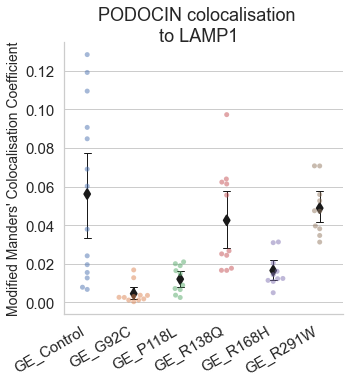

LAMP1 patient
no.images 20


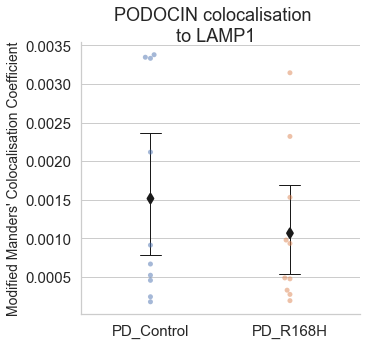

In [ ]:
#@markdown ###Manders' Colocalisation Coefficient of NPHS2 localising to subcellular markers
save_graphs = True#@param {type: 'boolean'}
graph_type = "swarmplot"#@param ["swarmplot", "stripplot"]
# FUNCTION
def stripd(df, x, y, title=None, xlabel=None, ylabel=None, boxplot_col=None, 
           scatter_col=None, scatter_palette=None, ylimit=None, 
           title_prepend="", with_image_labels=False,
           figsize=(3,3), hue=None, alpha=1, context_type="notebook", rotate_x=0, 
           stat_test="t-test_welch", pairs=[], graph_type="stripplot", errorbar="se",
           diamond_scale=1,
            errwidth=1,
            capsize=0.2, fontsize_stats=23):
        if xlabel is None: xlabel = x
        if ylabel is None: ylabel = y
        if title is None: title=f"{title_prepend}\n{x.capitalize()} vs. {y.capitalize()}"

        sns.set(style="whitegrid")

        # dot plots
        fig = plt.figure(figsize=figsize)
        sns.set_context(context_type)
        if graph_type == "swarmplot":
            ax = sns.swarmplot(data=df,x=x, y=y, hue=hue,color=scatter_col, palette=scatter_palette, alpha=alpha)#size=a*4
        elif graph_type == "stripplot":
            ax = sns.stripplot(data=df,x=x, y=y, hue=hue,color=scatter_col, palette=scatter_palette, alpha=alpha)#size=a*4
        if rotate_x > 0: ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_x, ha="right", fontsize=15)
        else: ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_x, ha="center", fontsize=15)
        plt.yticks(fontsize=15)

        # black mean and errorbar plot
        if hue: plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        sns.pointplot(x=x, y=y,
              data=df,
              join=False, color=boxplot_col,
              markers="d", errorbar=errorbar, ax=ax, verbose=True,
              scale=diamond_scale,
              errwidth=errwidth,
              capsize=capsize
              )#scale=3,

        # formatting graph
        #sns.set(font_scale=2)
        sns.despine(fig,ax)
        if ylimit: ax.set(ylim=(0, ylimit))
        fig.suptitle(title, fontsize=18)
        plt.xlabel(xlabel, fontsize=14)
        plt.ylabel(ylabel, fontsize=14)        

        # Add annotations
        def significance_stars(p_val):
            if p_val > 0.05:
                return "ns"
            if p_val > 0.01:
                return "*"
            elif p_val > 0.001:
                return "**"
            elif p_val > 0.0001:
                return "***"
            else:
                return "****"

        for group1, group2 in pairs:
            t, pval = stats.ttest_ind(df[df[x]==group1][y], df[df[x]==group2][y], equal_var=False)
            #stats.ttest_ind(df[df[x]==group1][y], df[df[x]==group2][y], equal_var=False)
            print(f"{group1} vs. {group2}: Welch's t-test independent samples, P_val:{pval} t={t}")
            x_coord = list(df[x].unique()).index(group1)
            plt.text(x=x_coord, y=ax.get_ylim()[1]*0.95, s=significance_stars(pval), 
                     ha='center', va='center', fontsize=fontsize_stats)
            
        
        plt.show()
        return fig, ax

# SCRIPT

stattest_rows = []
    
for line in ["mutant", "patient"]:
    # separate dfs into mutants and patient lines
    if line == "mutant": 
        df = deepcopy(df_all.loc[df_all['condition'].str.contains("GE")])
        rotate_x = 30
        control_cond = "GE_Control"
    elif line == "patient": 
        df = deepcopy(df_all.loc[df_all['condition'].str.contains("PD")])
        rotate_x = 0
        control_cond = "PD_Control"        
        

    # determine pairs of conditions to run stat test on (pooled controls)
    pairs = []
    for condition in df["condition"].unique():
        if "Control" not in condition:
            pairs.append((condition, control_cond))
    pairs = sorted(pairs)
        
    for channel1 in ["LAMP1"]:#CHANNEL1s:
        # graph m2
        print(channel1, line)
        print("no.images", len(df[(df["image1 channel"]==channel1) 
        & (df["metric name"]=='m2') & (df["image2 channel"]=='NPHS2')]))
        if channel1=="SYNPO":
            channel1_name = "SYNAPTOPODIN"
        else:
            channel1_name = channel1.upper()

        fig,ax = stripd(
            df[(df["image1 channel"]==channel1) & (df["metric name"]=='m2') & (df["image2 channel"]=='NPHS2')], 
            x="condition", 
            y="metric value",
            title=f"PODOCIN colocalisation \nto {channel1_name}\n", 
            xlabel="", 
            ylabel=f"Modified Manders' Colocalisation Coefficient", 
            boxplot_col="k",
            scatter_col=None, 
            scatter_palette=None, 
            ylimit=None, 
            title_prepend="", 
            with_image_labels=False, 
            figsize=(5,5), 
            hue=None, 
            alpha=0.5,
            context_type="notebook", 
            rotate_x=rotate_x,
            pairs=[],
            diamond_scale=1,
            errwidth=1,
            capsize=0.15,
            graph_type=graph_type
            )
        
        if save_graphs:
          fig.savefig(os.path.join(graphs_fp, f"{channel1} NPHS2 {line} m2 NO STATS.png"), bbox_inches='tight', dpi=300)


no. images: 984


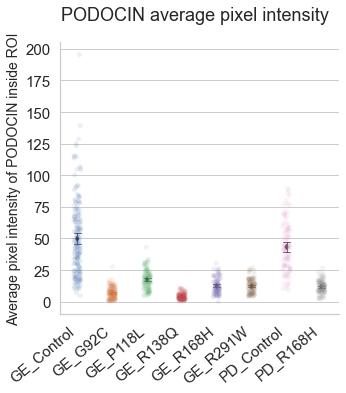

no. images: 893


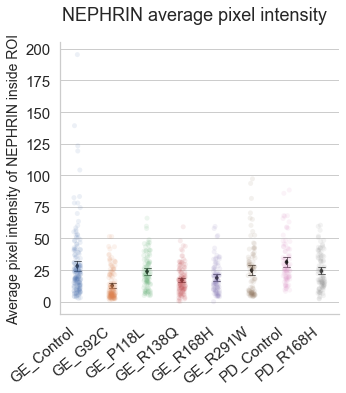

In [ ]:
#@markdown ### Average pixel intensity of NPHS2 and NPHS1
save_graphs = True#@param {type: 'boolean'}
graph_type = "stripplot"#@param ["swarmplot", "stripplot", "violinplot"]
# FUNCTION


def violind(df, x, y, title=None, xlabel=None, ylabel=None, boxplot_col=None, 
           scatter_col=None, scatter_palette=None, ylimit=None, 
           title_prepend="", with_image_labels=False,
           figsize=(3,3), hue=None, alpha=1, context_type="notebook", rotate_x=0, 
           stat_test="t-test_welch", pairs=[], violin_inner=None,
            errorbar="se", diamond_scale=1, errwidth=1,
            capsize=1):
        if xlabel is None: xlabel = x
        if ylabel is None: ylabel = y
        if title is None: title=f"{title_prepend}\n{x.capitalize()} vs. {y.capitalize()}"

        fig = plt.figure(figsize=figsize)
        sns.set_context(context_type)
        ax = sns.violinplot(data=df,x=x, y=y, cut=0, hue=hue,color=scatter_col, 
                            palette=scatter_palette, alpha=alpha, inner=violin_inner, scale="area")#size=a*4
        if rotate_x > 0: ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_x, ha="right")
        else: ax.set_xticklabels(ax.get_xticklabels(), rotation=rotate_x, ha="center")

        # black mean and errorbar plot
        if hue: plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        sns.pointplot(x=x, y=y,
              data=df,
              join=False, color=boxplot_col,
              markers="d", errorbar=errorbar, ax=ax, verbose=True, 
              scale=diamond_scale,
              errwidth=errwidth,
              capsize=capsize)#scale=3,
        
        ax.set(title=title,  xlabel=xlabel, ylabel=ylabel)
        if ylimit: ax.set(ylim=(0, ylimit))
     
        if with_image_labels:
            sns.set(font_scale=0.7,style="whitegrid")
            for i, img in enumerate(df["image_id"]):
                ax.annotate(img.split("_")[-1], (df[x][i], df[y][i]))
        
        # removes top and right border
        sns.despine(fig,ax)

        # Add annotations
        def significance_stars(p_val):
            if p_val > 0.05:
                return "ns"
            if p_val > 0.01:
                return "*"
            elif p_val > 0.001:
                return "**"
            elif p_val > 0.0001:
                return "***"
            else:
                return "****"

        for group1, group2 in pairs:
            t, pval = stats.ttest_ind(df[df[x]==group1][y], df[df[x]==group2][y], equal_var=False)
            print(f"{group1} vs. {group2}: Welch's t-test independent samples, P_val:{pval} t={t}")
            x_coord = list(df[x].unique()).index(group1)
            plt.text(x=x_coord, y=ax.get_ylim()[1], s=significance_stars(pval),  ha='center', va='center')

        plt.show()
        return fig, ax

# SCRIPT
for ch in ["NPHS2", "NPHS1"]:

    df = df_all[(df_all["metric name"]=='av_integrated_density2') & (df_all["image2 channel"]==ch)]

    # determine pairs of conditions to run stat test on (pooled controls)
    pairs = []
    for condition in df["condition"].unique():
        if (condition != "GE_Control") and (condition[:3]=="GE_"):
            pairs.append((condition, "GE_Control"))
    pairs = sorted(pairs)
    pairs.append(("PD_R168H", "PD_Control"))

    print("no. images:", len(df[(df["metric name"]=='av_integrated_density2') & (df["image2 channel"]==ch)]))
    if graph_type=="violinplot":
        fig,ax = violind(
            df, 
            x="condition", 
            y="metric value",
            title=f"{channel_meaning_dict[ch].upper()} average pixel intensity\n", 
            xlabel="", 
            ylabel=f"Average pixel intensity of {channel_meaning_dict[ch].upper()} inside ROI", 
            boxplot_col="k",
            scatter_col=None, 
            scatter_palette=None, 
            ylimit=None, 
            title_prepend="", 
            with_image_labels=False, 
            figsize=(5,5), 
            hue=None, 
            alpha=0.5,
            context_type="notebook", 
            rotate_x=40,
            pairs=pairs,
            diamond_scale=0.5,
            errwidth=0.7,
            capsize=0.2
            )
    else:
        fig,ax = stripd(
            df, 
            x="condition", 
            y="metric value",
            title=f"{channel_meaning_dict[ch].upper()} average pixel intensity\n", 
            xlabel="", 
            ylabel=f"Average pixel intensity of {channel_meaning_dict[ch].upper()} inside ROI", 
            boxplot_col="k",
            scatter_col=None, 
            scatter_palette=None, 
            ylimit=None, 
            title_prepend="", 
            with_image_labels=False, 
            figsize=(5,5), 
            hue=None, 
            alpha=0.1,
            context_type="notebook", 
            rotate_x=40,
            pairs=pairs,
            diamond_scale=0.5,
            errwidth=0.7,
            capsize=0.2,
            graph_type=graph_type,
            fontsize_stats=18
        )

    if save_graphs:
      fig.savefig(os.path.join(graphs_fp, f"{ch} average pixel intensity.png"), bbox_inches='tight', dpi=300)

KDEL -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\KDEL\NPHS2_NPHS1_2022-03-27_18-08-37_raw.csv
GM130 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\GM130\NPHS2_NPHS1_2022-03-27_17-07-08_raw.csv
Rab7 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\Rab7\NPHS2_NPHS1_2022-03-27_19-28-31_raw.csv
EEA1 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\EEA1\NPHS2_NPHS1_2022-03-27_16-44-31_raw.csv
LAMP1 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\LAMP1\NPHS2_NPHS1_2022-03-27_17-46-59_raw.csv
no. images 893


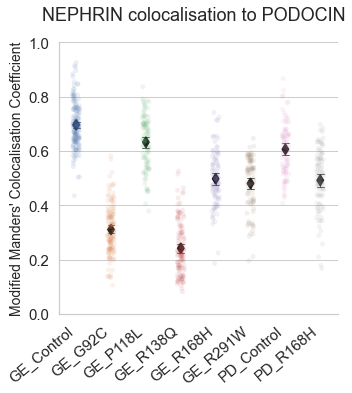

KDEL -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\KDEL\NPHS1_NPHS2_2022-03-27_18-10-07_raw.csv
GM130 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\GM130\NPHS1_NPHS2_2022-03-27_17-08-04_raw.csv
Rab7 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\Rab7\NPHS1_NPHS2_2022-03-27_19-29-42_raw.csv
EEA1 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\EEA1\NPHS1_NPHS2_2022-03-27_16-44-57_raw.csv
LAMP1 -----------------------------------------------
     \\data.mcri.edu.au\kidn1\Group-Little_MCRI\People\Thanushi\aude\dataset analysis\LAMP1\NPHS1_NPHS2_2022-03-27_17-47-21_raw.csv
no. images 893


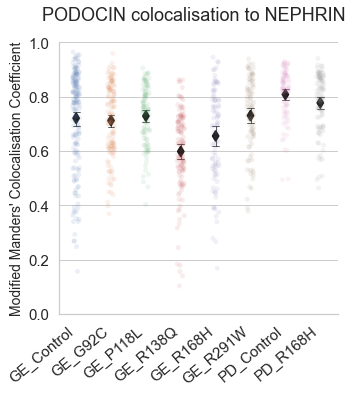

In [ ]:
#@markdown ###NPHS2 and NPHS1 colocalisation
save_graphs = True#@param {type: 'boolean'}
graph_type = "stripplot"#@param ["swarmplot", "stripplot", "violinplot"]

for ch1,ch2 in [("NPHS2", "NPHS1"), ("NPHS1", "NPHS2")]:

    # collate the correct csvs
    pd_all = []
    for channel1 in ['KDEL', 'GM130', 'Rab7', 'EEA1', 'LAMP1']:
        # get csv with subcellular marker in filename
        print(channel1, "-----------------------------------------------")
        csv_fp = [fp for fp in sorted(glob.glob(os.path.join(data_analysis_fp, channel1, fr'{ch1}_{ch2}*.csv'))) if "raw" in fp][0]
        
        print("    ", csv_fp)
        # collate into big df with all subcellular marker data
        pd_all.append(pd.read_csv(csv_fp))
    df = pd.concat(pd_all, axis=0, ignore_index=True)

    # renaming conditions
    df.loc[df['condition'].isin(["Proband", "pro_", 'Proband_R168H']), 'condition'] = "PD_R168H"
    df.loc[df['condition'].isin(set(CONTROL_CONDITIONS) & set(mutant_lines)), 'condition'] = "GE_Control"
    df.loc[df['condition'].isin(set(CONTROL_CONDITIONS) & set(patient_lines)), 'condition'] = "PD_Control"
    df['condition'] = df['condition'].apply(lambda s: f"GE_{s}" if s in set(mutant_lines) else s)

    # determine pairs of conditions to run stat test on (pooled controls)
    pairs = []
    for condition in df["condition"].unique():
        if (condition != "GE_Control") and (condition[:3]=="GE_"):
            pairs.append((condition, "GE_Control"))
    pairs = sorted(pairs)
    pairs.append(("PD_R168H", "PD_Control"))
    
    print("no. images", len(df[(df["metric name"]=='m2') & (df["image1 channel"]==ch1) & (df["image2 channel"]==ch2)]))
    
    if graph_type=="violinplot":
        fig,ax = violind(
            df[(df["metric name"]=='m2') & (df["image1 channel"]==ch1) & (df["image2 channel"]==ch2)], 
            x="condition", 
            y="metric value",
            title=f"{channel_meaning_dict[ch2].upper()} colocalisation to {channel_meaning_dict[ch1].upper()}\n", 
            xlabel="", 
            ylabel=f"Modified Manders' Colocalisation Coefficient", 
            boxplot_col="k",
            scatter_col=None, 
            scatter_palette=None, 
            ylimit=1, 
            title_prepend="", 
            with_image_labels=False, 
            figsize=(5,5), 
            hue=None, 
            alpha=0.5,
            context_type="notebook", 
            rotate_x=40,
            pairs=pairs,
            diamond_scale=1,
            errwidth=0.7,
            capsize=0.2
        )
    else:
        fig,ax = stripd(
            df[(df["metric name"]=='m2') & (df["image1 channel"]==ch1) & (df["image2 channel"]==ch2)], 
            x="condition", 
            y="metric value",
            title=f"{channel_meaning_dict[ch2].upper()} colocalisation to {channel_meaning_dict[ch1].upper()}\n", 
            xlabel="", 
            ylabel=f"Modified Manders' Colocalisation Coefficient", 
            boxplot_col="k",
            scatter_col=None, 
            scatter_palette=None, 
            ylimit=1, 
            title_prepend="", 
            with_image_labels=False, 
            figsize=(5,5), 
            hue=None, 
            alpha=0.1,
            context_type="notebook", 
            rotate_x=40,
            pairs=[],
            diamond_scale=1,
            errwidth=0.7,
            capsize=0.2,
            graph_type=graph_type,
            fontsize_stats=18
        )

    if save_graphs:
      fig.savefig(os.path.join(graphs_fp, f"{ch1} {ch2} combined m2 NO STAT.png"), bbox_inches='tight', dpi=300)